In [52]:
import pandas as pd
import numpy as np
import get_prices as hist
import tensorflow as tf
from preprocessing import DataProcessing
import pandas_datareader.data as pdr
import fix_yahoo_finance as fix
import matplotlib.pyplot as plt
fix.pdr_override()

In [53]:
def my_plot(history, head, save, model_name):
    loss = history.history['loss'][head:]
    val_loss = history.history['val_loss'][head:]
    epochs = range(head + 1, len(loss) + head + 1)
    plt.plot(epochs, loss, color='orange', label='Train')
    plt.plot(epochs, val_loss, color='green', label='Validation')
    plt.title(model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if save:
        plt.savefig("figures/" + model_name + ".{}head".format(head) + ".png", dpi=250)

In [54]:
model_base_name = "{}.{}ep.{}lr"

In [55]:
start = "2003-01-01"
end = "2018-01-01"

hist.get_stock_data("AAPL", start_date=start, end_date=end)
process = DataProcessing("stock_prices.csv", 1.0)
# process.gen_test(10)
process.gen_train(10)

[*********************100%***********************]  1 of 1 downloaded


/home/lab/isabella/stockprice_prediction/get_prices.py:32: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  stock_data.to_csv("stock_prices.csv")


In [56]:
XY_total = [(process.X_train[i], process.Y_train[i]) for i in range(len(process.X_train))]
np.random.shuffle(XY_total)

In [57]:
i_split = int(0.9 * len(XY_total))
XY_train = XY_total[:i_split]
X_train = np.asarray([t[0] for t in XY_train])
X_train = X_train.reshape((len(X_train), 10, 1)) / 200
Y_train = np.asarray([t[1] for t in XY_train]) / 200

XY_val = XY_total[i_split:]
X_val = np.asarray([t[0] for t in XY_val])
X_val = X_val.reshape((len(X_val), 10, 1)) / 200
Y_val = np.asarray([t[1] for t in XY_val]) / 200

# Models

In [77]:
from tensorflow.keras.layers import Convolution1D, LSTM, Dropout, Dense, MaxPooling1D, Flatten

## CNN model

In [66]:
epochs = 50
lr = 0.00001
d_rate = 0.4
n_filters = 64
kernel_size = 2

In [62]:
model_name = model_base_name.format(
    "CNN",
    epochs,
    lr
)

In [78]:
model = tf.keras.Sequential()
# model.add(Dense(128, activation='relu',input_shape=(10, 1)))
model.add(Convolution1D(input_shape=(10, 1),
                        filters=n_filters, 
                        kernel_size=kernel_size,
                        activation='relu', 
#                         padding='valid', 
#                         strides=1
                       )
         )
model.add(MaxPooling1D(pool_size=1))
# model.add(tf.keras.layers.Convolution1D(20))
model.add(Dropout(d_rate))
model.add(Flatten())
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
model.compile(optimizer=adam, loss="mean_squared_error")

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9, 64)             192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 577       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

Train on 3379 samples, validate on 359 samples
Epoch 1/50
3379/3379 [==============================] - 1s 427us/sample - loss: 0.0499 - val_loss: 0.3077
Epoch 2/50
3379/3379 [==============================] - 1s 149us/sample - loss: 0.0286 - val_loss: 0.1853
Epoch 3/50
3379/3379 [==============================] - 1s 153us/sample - loss: 0.0180 - val_loss: 0.1252
Epoch 4/50
3379/3379 [==============================] - 1s 151us/sample - loss: 0.0121 - val_loss: 0.0890
Epoch 5/50
3379/3379 [==============================] - 1s 152us/sample - loss: 0.0091 - val_loss: 0.0659
Epoch 6/50
3379/3379 [==============================] - 1s 152us/sample - loss: 0.0075 - val_loss: 0.0494
Epoch 7/50
3379/3379 [==============================] - 1s 153us/sample - loss: 0.0064 - val_loss: 0.0380
Epoch 8/50
3379/3379 [==============================] - 1s 155us/sample - loss: 0.0058 - val_loss: 0.0299
Epoch 9/50
3379/3379 [==============================] - 1s 152us/sample - loss: 0.0050 - val_loss: 0.0242

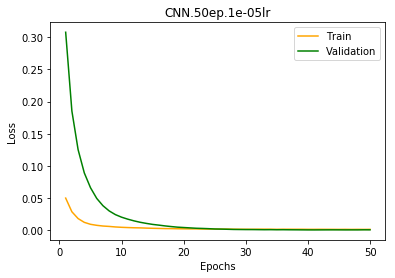

In [81]:
my_plot(history, 0, True, model_name)

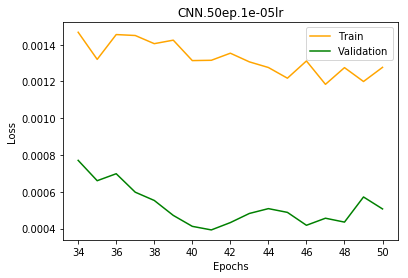

In [82]:
my_plot(history, 33, True, model_name)

## LSTM model

In [65]:
epochs = 50
lr = 0.00001

In [66]:
adam = tf.keras.optimizers.Adam(lr=lr)

In [67]:
model_name = model_base_name.format(
    "LSTM",
    epochs,
    lr
)

In [68]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20, input_shape=(10, 1), return_sequences=True))
model.add(tf.keras.layers.LSTM(20))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))

model.compile(optimizer=adam, loss="mean_squared_error")

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 20)            1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

Train on 3383 samples, validate on 376 samples
Epoch 1/50
3383/3383 [==============================] - 6s 2ms/sample - loss: 0.0677 - val_loss: 0.0575
Epoch 2/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0602 - val_loss: 0.0509
Epoch 3/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0532 - val_loss: 0.0447
Epoch 4/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0468 - val_loss: 0.0391
Epoch 5/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0407 - val_loss: 0.0338
Epoch 6/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0352 - val_loss: 0.0291
Epoch 7/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0301 - val_loss: 0.0248
Epoch 8/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0256 - val_loss: 0.0210
Epoch 9/50
3383/3383 [==============================] - 5s 1ms/sample - loss: 0.0217 - val_loss: 0.0179
Epoch 10/50
3383/

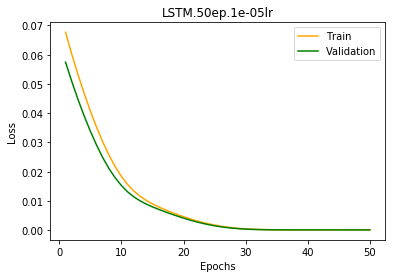

In [71]:
my_plot(history, 0, True, model_name)

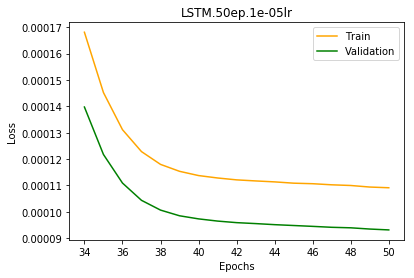

In [72]:
my_plot(history, 33, True, model_name)

# Prediction

In [73]:
test_csv = "stock_prices_test.csv"
def save_stock_data(ticker, start_date, end_date):
    i = 1
    try:
        all_data = pdr.get_data_yahoo(ticker, start_date, end_date)
    except ValueError:
        print("ValueError, trying again")
        i += 1
        if i < 5:
            time.sleep(10)
            get_stock_data(ticker, start_date, end_date)
        else:
            print("Tried 5 times, Yahoo error. Trying after 2 minutes")
            time.sleep(120)
            get_stock_data(ticker, start_date, end_date)
    stock_data = all_data["Adj Close"]
    stock_data.to_csv(test_csv)

In [80]:
def my_pred_plot(pred, test, save):
    samples = range(1, len(test) + 1)
    plt.plot(samples, pred, color='orange', label='Prediction')
    plt.plot(samples, test, color='green', label='Actual value')
    plt.title(model_name)
    plt.xlabel('Samples')
    plt.ylabel('Stock value')
    plt.legend()
    if save:
        plt.savefig("figures/" + model_name + ".pred" + ".png", dpi=250)

In [96]:
save_stock_data("AAPL", "2013-03-01", "2016-09-30")
process_test = DataProcessing("stock_prices_test.csv", 1.0)
process_test.gen_train(10)
X_test = process_test.X_train.reshape((len(process_test.X_train), 10, 1)) / 200
Y_test = process_test.Y_train

[*********************100%***********************]  1 of 1 downloaded


/home/lab/isabella/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [97]:
Y_predict = model.predict(X_test)*200

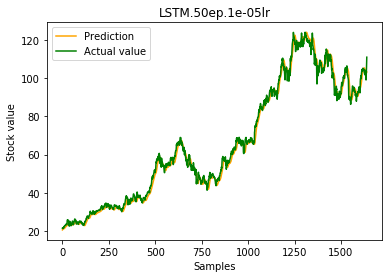

In [98]:
my_pred_plot(Y_predict[0:], Y_test[0:], False)